In [1]:

import seaborn as sns
import matplotlib.pyplot as plt
import cv2 , math , os , pandas as pd , numpy as np 
import warnings
from tqdm import trange
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format='retina'
np.set_printoptions(suppress=True)

columns = 52
rows = 4


# WOA

In [3]:
def n_fold():
    
    xls = pd.ExcelFile('/Users/tae/Desktop/Project/Code/Excel/dataset50Convolution.xlsx')
#     xls = pd.ExcelFile('/Users/tae/Desktop/Project/Dataset/finalDaset.xlsx')
   
    dc1 = pd.read_excel(xls, 'Sheet1' , header=None)
    dc2 = pd.read_excel(xls, 'Sheet2' , header=None)
    dc3 = pd.read_excel(xls, 'Sheet3' , header=None)
    dc4 = pd.read_excel(xls, 'Sheet4' , header=None)


    
    a1 = len(dc1) // 10-1
    a2 = len(dc2) // 10-1
    a3 = len(dc3) // 10-1
    a4 = len(dc4) // 10-1
    
    train = np.empty(10 , dtype='object')
    test = np.empty(10 , dtype='object')

    for cj in range(1,11):

        if cj == 10:
            
            stdc1 = (cj-1) * (a1+1)
            ftdc1 = len(dc1)
            
            stdc2 = (cj-1) * (a2+1)
            ftdc2 = len(dc2)
            
            stdc3 = (cj-1) * (a3+1);
            ftdc3 = len(dc3)
            
            stdc4= (cj-1) * (a4+1);
            ftdc4 = len(dc4)
            
        else:
            stdc1 = (cj-1) * (a1+1)
            ftdc1 = stdc1+a1
            
            stdc2 = (cj-1) * (a2+1)
            ftdc2 = stdc2+a2
            
            stdc3 = (cj-1) * (a3+1)
            ftdc3 = stdc3+a3
            
            stdc4 = (cj-1) * (a4+1)
            ftdc4 = stdc4+a4
            
        Dtest1 = dc1[stdc1:ftdc1+1]
        Dtest2 = dc2[stdc2:ftdc2+1]
        Dtest3 = dc3[stdc3:ftdc3+1]
        Dtest4 = dc4[stdc4:ftdc4+1]

        Dtrain1 = dc1.drop(dc1.index[stdc1:ftdc1+1])
        Dtrain2 = dc2.drop(dc2.index[stdc2:ftdc2+1])
        Dtrain3 = dc3.drop(dc3.index[stdc3:ftdc3+1])
        Dtrain4 = dc4.drop(dc4.index[stdc4:ftdc4+1])

        test[cj-1] =  pd.concat([Dtest1, Dtest2,  Dtest3 , Dtest4],ignore_index=True).to_numpy()
        train[cj-1] = pd.concat([Dtrain1,Dtrain2, Dtrain3 ,Dtrain4], ignore_index=True).to_numpy()
    
    return train , test


def initial_pop(size=10):
    c_whale = np.empty(size , dtype='object')
    for i in range(size):
        c_whale[i] = np.random.rand(rows,columns)
    return c_whale


def evaluate_fitness(population , data_train):
    score_fitness = []
    for pop in population:
        count = 0
        for i in range(len(data_train)):
            data_clone = np.tile(data_train[i][:columns] , (rows,1))
            label  = data_train[i][-2:-1]
            distance = np.argmin(np.sqrt(np.sum((data_clone - pop)**2 , axis=1)))
            if distance+1 == label:
                count = count + 1
        score_fitness.append(count)
    score_fitness = np.array(score_fitness)
    gbest = population[np.argmax(score_fitness)]
   
    return score_fitness , gbest

def woa(population , gbest , data_train):
    count = 0
    max_iter = 3000
    pxi = 0.5
    threshold = 0.5 * max_iter
    before_best = 0
    value = []
    graph = []
    repeat = None
    
    for iteration in trange(max_iter+1):
        
        a = 2 * (1- iteration / max_iter)
        l = (-1 + (-iteration / max_iter) - 1) * np.random.rand(rows, columns) + 1
        A = a * (2 * np.random.rand() -1)
        C = 2 * np.random.rand()
        
        new_population = np.empty(10 , dtype='object')
    
        for idx_pop in range(len(population)):
            pop = population[idx_pop]
            
            if np.random.rand() < 0.5:
                if np.abs(np.sum(A)) < 1:
                    Xrand = np.random.rand(rows,columns) 
                    D = np.abs(C * Xrand - pop)
                    new_position = Xrand - A * D
                else:
                    D = np.abs(C * gbest - pop)
                    new_position = gbest - A * D
                    
            else:

                D = np.sqrt(np.sum((gbest-pop)**2))
                new_position = D * np.exp(1*l) * np.cos(2 * np.pi * l) + gbest
            
            new_population[idx_pop] = np.clip(new_position , a_min=0,a_max=1)
    
            
        combined = np.concatenate((population , new_population))
        score , new_gbest = evaluate_fitness(combined , data_train)
        topten_idx = np.argsort(score)[::-1]
        population = combined[topten_idx[:10]]
        best_perfomance = score[np.argmax(score)]
        value.append(best_perfomance)
        gbest = new_gbest

       
            
        if before_best == best_perfomance:
            count = count + 1
            if count > 3:
                for x in range(1,len(population)):
                    if x in {1,2,3}:
                        newW = (0.1 * np.random.rand(rows,columns)) - 0.05
                        population[x] = np.clip(population[0] + newW , a_min=0 , a_max=1)
                    else:
                        population[x] = np.random.rand(rows,columns)
                        
#             if count > threshold:
#                 break
        else:
        
            before_best = best_perfomance
            count = 0 

    return value , gbest

def test_model(model , dataTest):
    
    only_data = dataTest[:,:columns]
    class_data = dataTest[:,-2:-1]
    count = 0
    
    for i in range(len(dataTest)):
        md = np.tile(only_data[i] , (rows,1))
        dis = np.sqrt( np.sum((model - md)**2 , axis=1) )
        
        if np.argmin(dis)+1 == class_data[i]:
            count = count+1

    return count

In [4]:
def plot_allGraph(arr_graph):
    sns.set_theme(style='darkgrid',palette="deep")
    sns.set_context("paper")
    
    plt.figure(figsize=(30,8))
    
    for idx , graph  in enumerate(arr_graph ,start=1):
        plt.subplot(2,5,idx)
        sns.lineplot(arr_graph[idx-1] , markers='-')
        # plt.savefig('allGraph100_unnormalize.png', bbox_inches='tight')
    plt.show()





In [5]:
def plot_matchGraph(arr_graph):
    
    sns.set_theme(style="darkgrid", palette="bright")
    sns.set_context("paper")
    plt.figure(figsize=(25,8))
    
    for idx, graph in enumerate(arr_graph):
        sns.lineplot(x=range(len(graph)) , y=graph , label=f'Whale {idx}')
        # plt.savefig('matchGraph100_unnormalize.png', bbox_inches='tight')




In [6]:
########
# main #
train , test  = n_fold()
arr_graph = []
arr_model = []
accuracy = []

for i in range(1):
    pop = initial_pop()
    score , gbest = evaluate_fitness(pop , train[i])
    graph , model = woa(pop,gbest,train[i])
    arr_model.append(model)
    arr_graph.append(graph)
    acc = test_model(model , test[i])
    accuracy.append((len(test[i]) , acc , acc / len(test[i])))

#######

100%|███████████████████████████████████████| 3001/3001 [22:58<00:00,  2.18it/s]


In [7]:
arr_accuracy = np.array(accuracy)
print(arr_accuracy)
print('_'*50)
print('Average:',np.average(arr_accuracy[:,2]))
print('STD:',np.std(arr_accuracy[:,2]))

[[405.         362.           0.89382716]]
__________________________________________________
Average: 0.8938271604938272
STD: 0.0


In [ ]:
# Export

finalmodel = arr_model[np.argmax(arr_accuracy[:,2])]
finalmodel =   pd.DataFrame(finalmodel)
finalmodel.to_excel('/Users/tae/Desktop/Project/Dataset/model_dataset100.xlsx' , header=None , index=None)

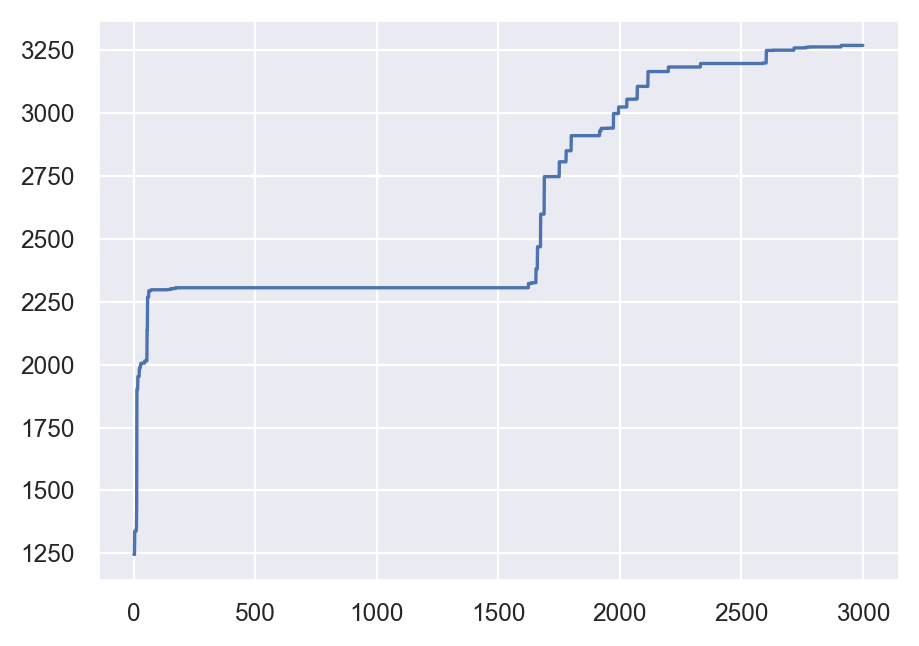

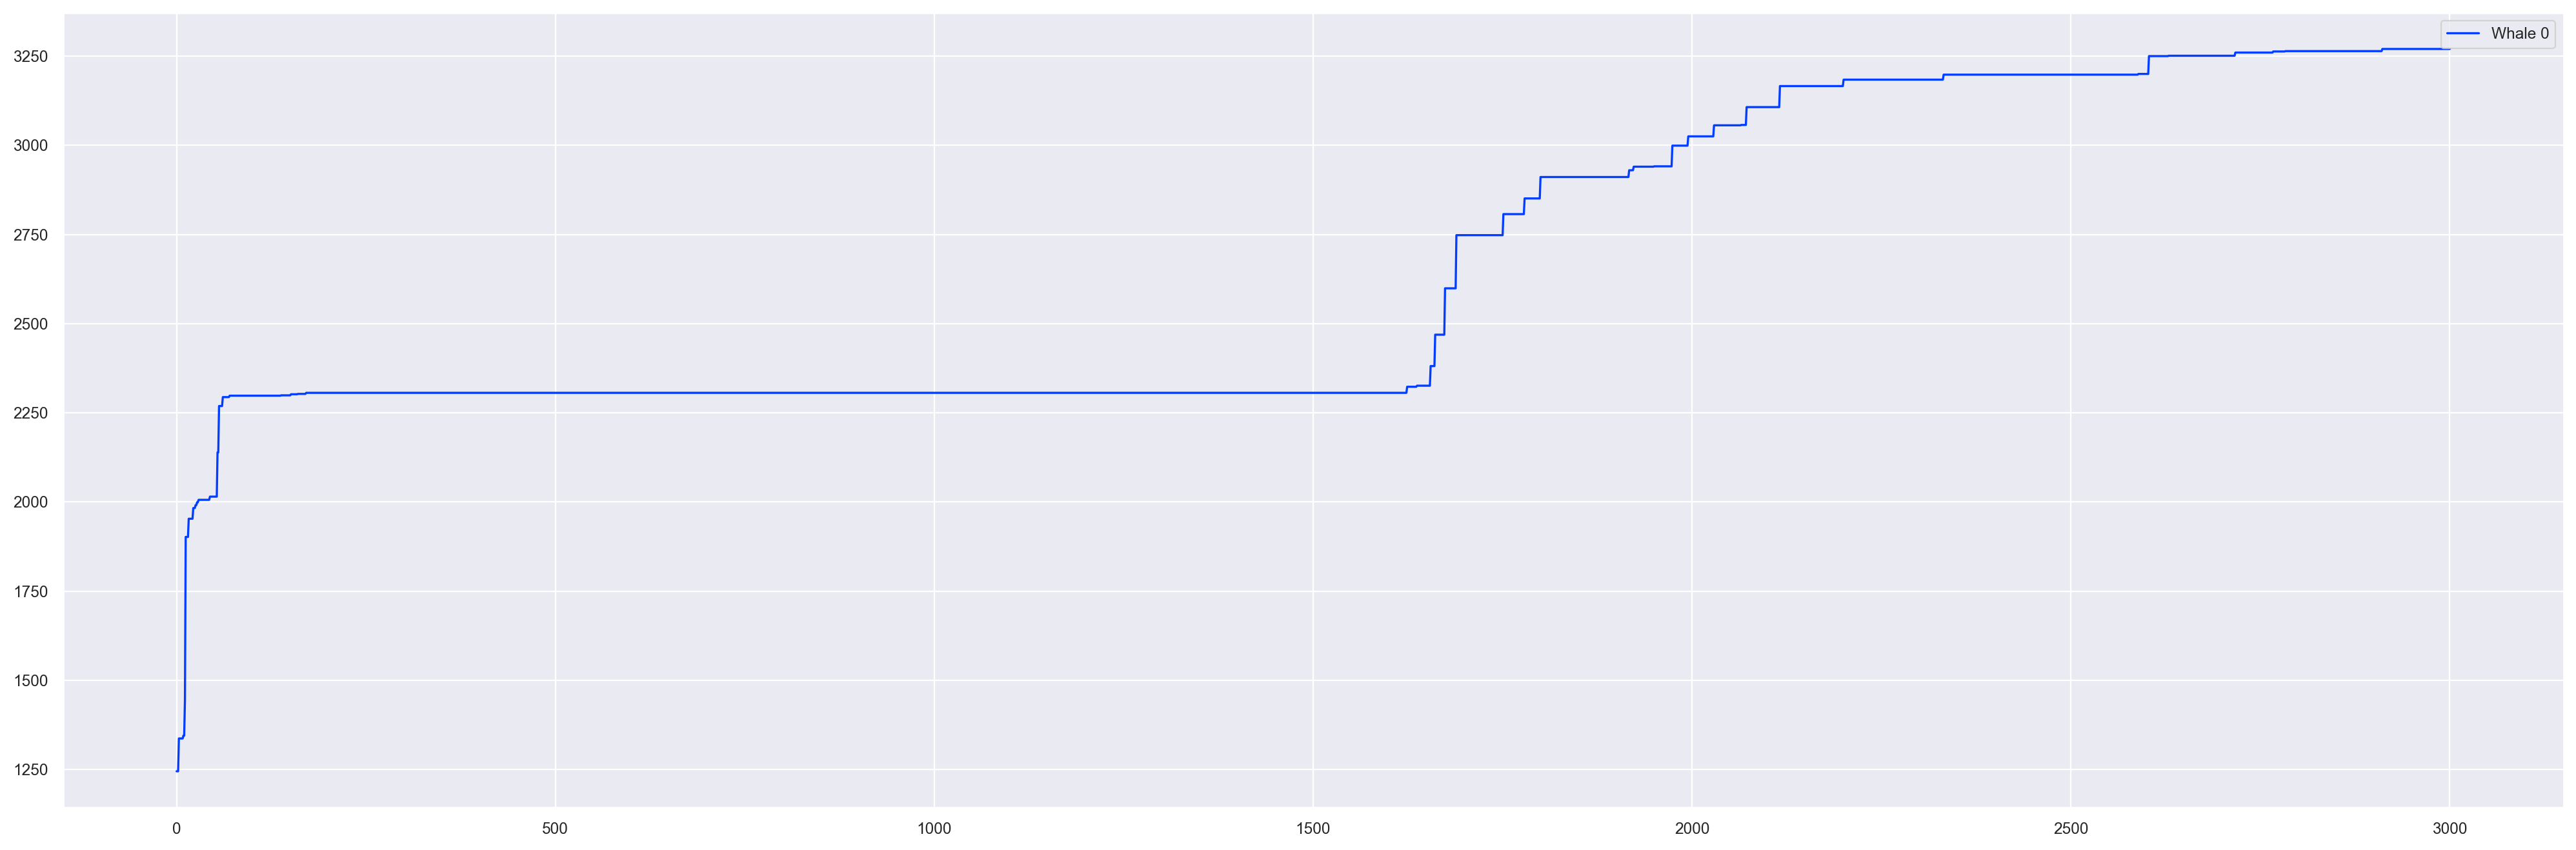

In [8]:
# Graph visualize

plot_allGraph(arr_graph)
plot_matchGraph(arr_graph)

# Detection

In [ ]:

# Class1 = 1180 Black_rot
# Class2 = 1383 Black_Measles
# Class3 = 1076 Lsariopsis_Leaf_Spot
# Class4 = 423 Healthy


def evaluate_model(model , dataTest):

    class_labels = {
        1:'1Grape___Black_rot',
        2:'2Grape___Esca_(Black_Measles)',
        3:'3Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
        4:'4Grape___healthy'
    }
    
    data = dataTest[:,:columns]
    label = dataTest[:,-2:-1]
    imgname = dataTest[:,-1:]
    count = 0
    
    for i in range(len(dataTest)):

            
        data_clone = np.tile(data[i] , (rows,1))
        distance = np.sqrt( np.sum((model - data_clone)**2 , axis=1) )
        predicted = np.argmin(distance)
        
        label_name = class_labels.get(int(label[i]))
        predicted_name = class_labels.get(int(predicted+1))
        image_name = int(imgname[i]),'.jpg'
        
        if predicted+1 == label[i]:
            count = count+1
        
            print('Label:' , label_name)
            print('Predicted:', predicted_name )
            print('True ✅')
            
            imgpath = os.path.join(f'/Users/tae/Desktop/Project/image/{class_labels.get(int(label[i]))}/', f'{int(imgname[i])}.jpg')
            print(imgpath)
            watershed(imgpath , label_name)

        else:
            print('Label:' , label_name)
            print('Predicted:', predicted_name )
            print('False ❌')
            imgpath = os.path.join(f'/Users/tae/Desktop/Project/image/{class_labels.get(int(label[i]))}/', f'{int(imgname[i])}.jpg')

    print(f'Predict True: {count}/{len(dataTest)}')
            

    return count






In [ ]:
def watershed(path , label_name):
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image,  cv2.COLOR_BGR2RGB)
    
    if label_name == '4Grape___healthy':
        plt.figure(figsize=(4,4))
        plt.imshow(image)
        plt.title('Predict correct')
        plt.axis(False)
        plt.show()
        
    else:


        # img_copy = image_rgb.copy()
        img_recog = image_rgb.copy()  # กำหนดค่าเริ่มต้นให้ img_recog เป็นภาพหลักของ image_rgb

        img_hsv = cv2.cvtColor(image_rgb , cv2.COLOR_RGB2HSV)
        lower = np.array([30,30,30])
        upper = np.array([90,255,255])
        mask = cv2.inRange(img_hsv , lower , upper)
        kernel = np.ones((3,3) , np.uint8)
        
        median = cv2.medianBlur(mask , 5)
        opening = cv2.dilate(median , kernel)
        closing = cv2.erode(opening , kernel)
        
        contours , hierachy = cv2.findContours(closing, mode=cv2.RETR_TREE , method=cv2.CHAIN_APPROX_SIMPLE)

        for index , cnt in enumerate(contours):
            if cv2.contourArea(cnt) < 10000 and cv2.contourArea(cnt) > 10:
                x,y,w,h = cv2.boundingRect(cnt)
                img_recog = cv2.rectangle(img_recog , (x,y) , (x+w,y+h) , (255,0,0) , 1)
                cv2.putText(img_recog, f'{index}', (x, y),cv2.FONT_HERSHEY_COMPLEX, 0.3, (0, 255, 255), 1)

        plt.figure(figsize=(7,7))
        plt.subplot(121)
        plt.imshow(closing , cmap='gray')
        plt.title('Predict correct')
        plt.axis(False)
        
        plt.subplot(122)
        plt.imshow(img_recog)
        plt.title('Predict correct')
        plt.axis(False)    
        plt.show()
    
   
    return path

# Import model

In [ ]:
arr_model_extend = []
for x in arr_model:
    arr_model_extend.extend(x)
df = pd.DataFrame(arr_model_extend)
df
df.to_excel('/Users/tae/Desktop/Project/Dataset/modeldataset100ALL_unnormalize.xlsx' , header=None , index=None)

# Model from excel
df = pd.read_excel('/Users/tae/Desktop/Project/Dataset/model.xlsx' ,header=None )

# df = df.drop(columns=['Unnamed: 0'])
df_arr = df.to_numpy()

models = []
for i in range(10):
    models.append(df_arr[i*4:(i+1)*4 , :])

train , test = n_fold()

for n , m in enumerate(models):
    evaluate_model(m , test[n])
    input('Press Enter')